In [39]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from scipy import stats


import yahoo_fin.stock_info as finance

from simplejson.decoder import JSONDecodeError


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


#   Main Block started
class Generation:

    def __init__(self, based_symbol: str, show=False):
        self.based_symbol = based_symbol    # Symbol storage
        self.symbol_data = finance.get_data(self.based_symbol, start_date='2012-01-01',
                                            end_date="2018-01-01")  # Reference data
        self.trend_line = None  # Raw Trend
        self.trend_size = None  # Raw Trend size
        self.walking = None     # Stochastic dataset
        self.final_trend_line = None    # Buffer random walking
        self.final_size = None  # Buffer random walking size
        self.final_with_std = None  # Result of random walking algorithm
        self.final_size_std = None  # Size result of random walking algorithm
        self.bootstrap_data = None  # Raw dataset from bootstrap method
        self.combined_boot_trend = None     # All result

        self.collect_trend_line(info=False)
        if show:
            plt.figure(figsize=(8, 4))
            plt.plot(self.symbol_data["open"])
            plt.title('Input Raw Data')
            plt.show()

    def collect_trend_line(self, info=False):
        """
        Takes trend line from time-series data. It will help me to make more real dataset.
        So first parameter is BASED SYMBOL
        *Possible to replace with moving average line*
        :return:
        """
        if info:
            print('SHAPE INPUT', self.symbol_data.shape)

        trend_buffer = self.symbol_data["open"].squeeze().dropna()
        trend_buffer = trend_buffer.asfreq('M')
        for _arrow_ in reversed(range(trend_buffer.shape[0] - 1)):
            if trend_buffer[_arrow_].astype(str) == 'nan':
                trend_buffer[_arrow_] = trend_buffer[_arrow_+1]

        if info:
            print(trend_buffer)

        components = tsa.seasonal_decompose(trend_buffer, model='additive')
        ts = (trend_buffer.to_frame('Original').assign(
            Trend=components.trend).assign(Residual=components.resid)).dropna()

        trend_buffer = ts["Trend"].asfreq('d')
        if info:
            print("TREND LEN:", len(trend_buffer))
        for i in reversed(range(trend_buffer.shape[0])):
            if trend_buffer[i].astype(str) == 'nan':
               trend_buffer[i] = trend_buffer[i+1]
        self.trend_line = trend_buffer
        self.trend_size = self.trend_line.shape[0] - 1
        del trend_buffer
        del components

    @classmethod
    def random_walking(cls, discrete_steps: int, continuous_steps: int, increment: float or int):
        """
        I will use it to create F(time) to input at NORMAL(TREND(time), F(time)).
        I make this in case that market time-series is not stationary row
        So this thing gives me ability to make STD function not equal in time
        :param discrete_steps: Usually will be int(365)
        :param continuous_steps:
        :param increment: STD parameter. At this step it is the most interesting parameter
        :return:
        """
        dt = 1 * continuous_steps / discrete_steps
        random_increment = np.random.normal(.0, increment, discrete_steps) * np.sqrt(dt)
        motion = np.cumsum(random_increment)
        motion = np.insert(motion, 0, 0.0)
        return motion, random_increment

    def create_random_walking_line(self, info=True, show=True):
        """
        :param info: Print info about random array
        :param show: Show graphic
        :return:
        """
        motion_average_control = 7
        zero_log_control = 5

        self.walking = moving_average(np.log(abs(Generation.random_walking(
            discrete_steps=self.trend_size + motion_average_control + zero_log_control, continuous_steps=1,
                                                 increment=2)[0])[5:]), motion_average_control + 1)
        if info:
            print(f"--------\nMEAN: {self.walking.mean()}\nSTD: {self.walking.std()}")
        if show:
            plt.figure(figsize=(12, 6))
            plt.grid()
            plt.plot(self.walking)
            plt.title('Random Walking')
            plt.show()

    def generate_new_trend_based_on_input(self, info=False, show=False):

        #   Not to change. Really dont touch it. Only few parameter, but better dont touch em too

        average_approx_strength = 25    # High strength parameter
        #   average_approx_strength = 15   # High strength parameter - 15 == Bigger Volatility
        #   average_approx_strength = 2
        smart_walking_smooth = 10

        frame = self.trend_line.to_frame()
        frame["Walk"] = self.walking
        stdd = self.symbol_data["open"].std()
        smart_walking = abs(np.array([stats.norm(x, stdd).rvs(1) for x in self.walking]))
        smart_walking = smart_walking.T[0]
        if info:
            print(smart_walking_smooth)
            print(stats.norm(self.walking[-1], stdd).rvs(smart_walking_smooth))
        smart_walking = np.hstack((smart_walking, abs(stats.norm(self.walking[-1], stdd).rvs(
                                                                    size=smart_walking_smooth))))
        if show:
            plt.figure(figsize=(12, 4))
            plt.title('Smart random')
            plt.plot(smart_walking)
            plt.show()
            frame.columns = ['Trend', 'Walk']

        if show:
            plt.figure(figsize=(18, 6))
            plt.title("Adding walk component to reference trend")
            plt.plot(frame["Trend"] + abs(np.cumsum((frame["Walk"]))))
            plt.show()

        move = moving_average(frame["Trend"] + abs(np.cumsum((frame["Walk"]))), average_approx_strength)
        move = move + (moving_average(smart_walking, smart_walking_smooth) *
                       (max(move) / max(smart_walking)))[:len(move)]
        move = np.hstack((move, move[-(average_approx_strength - 1):]))

        frame["NORM"] = move

        if info:
            print(len(self.walking))
            print(len(frame))
            print(move)

        self.final_trend_line = frame.NORM[:-average_approx_strength]
        self.final_size = len(frame) - average_approx_strength
        if show:
            plt.figure(figsize=(18, 6))
            plt.title("MOVING AVERAGE: Adding walk component to reference trend")
            plt.plot(self.final_trend_line)
            plt.show()
        del frame
        del move

    def create_std_final_trend(self, show=True, weight=(.8, .2)):
        """

        :param show:
        :param weight: way to control how interesting result will be.
        I took that numbers to create something like reference
        :return:
        """
        average_approx_strength = 2    # High strength parameter

        # FIXME:    Bad algorithm in new_array creation. Sometimes in creates huge volatility
        random = abs(Generation.random_walking(discrete_steps=self.final_size, continuous_steps=1, increment=70)[0][1:])
        new_array = []
        trend = self.final_trend_line
        for i in range(len(random)):
            new_array.append(weight[0] * trend[i] * weight[1] * 100 * random[i])

        new_array = moving_average(new_array, average_approx_strength)  # Problem solution is to use moving average
        #   May create some problems

        normalize_coff = max(new_array) / max(trend)

        new_array = np.array(new_array) / normalize_coff

        new_array = new_array + stats.norm(100, self.symbol_data["open"].std()).rvs()

        #   stats.norm is: Simple way to set not_zero_start
        #   It will help me to create sync bootstrap method

        if show:
            fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 6))
            ax[0].set_title('TREND_LINE')
            ax[0].plot(self.final_trend_line.values)
            ax[1].set_title('TREND WITH STD')
            ax[1].plot(new_array)
            ax[2].set_title('REFERENCE LINE')
            ax[2].plot(self.symbol_data["open"][:self.final_size].values)

        self.final_with_std = new_array
        self.final_size_std = len(new_array)

    #   BLOCK WITH BOOTSTRAP METHOD
    def make_bootstrap_data(self, show=True, info=False):
        start_price = self.final_with_std[0]
        all_samples = self.symbol_data["open"].pct_change().dropna()
        if info:
            print("START PRICE:", start_price)
            print(all_samples)
        prices = list()
        for _arrow_ in range(self.final_size_std):
            start_price *= (1 + np.random.choice(all_samples))
            prices.append(start_price)
        prices = np.array(prices)
        prices = prices / max(prices)
        if show:
            plt.figure(figsize=(12, 4))
            plt.title('Bootstrap graph')
            plt.plot(prices)
            plt.show()
        self.bootstrap_data = prices

    def combine_trend_bootstrap(self, show=True, weights=(0.75, 0.25)):
        boot_trend = self.final_with_std * weights[0] * weights[1] * (self.bootstrap_data / max(self.bootstrap_data))
        boot_trend = boot_trend / (boot_trend[0] / self.final_with_std[0])
        boot_trend = boot_trend / (boot_trend.mean() / self.symbol_data["open"].values.mean())
        if show:
            plt.figure(figsize=(12, 4))
            plt.title("SYNTH DATA")
            plt.plot(boot_trend)
            plt.show()
            plt.figure(figsize=(12, 4))
            plt.title("REAL DATA")
            plt.plot(self.symbol_data["open"].values[:self.final_size_std])
            plt.show()

        self.combined_boot_trend = abs(boot_trend)

#   Main Block end

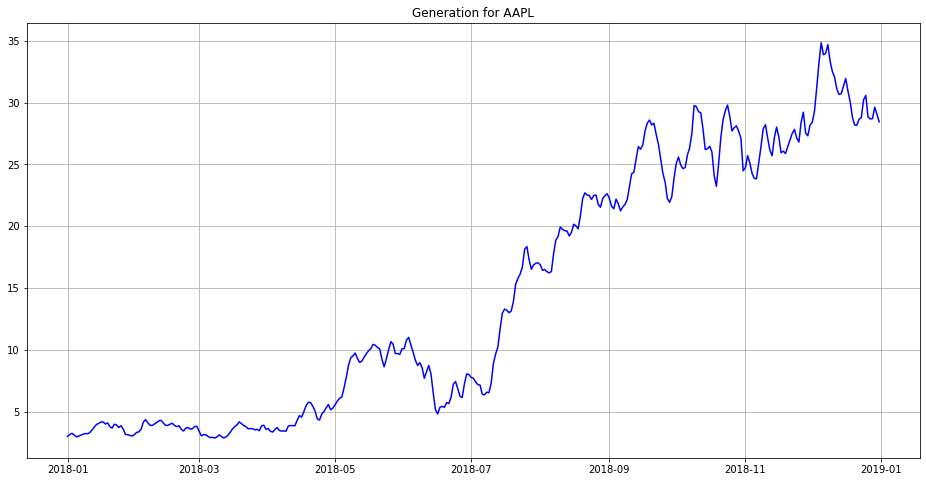

In [40]:
symbol='AAPL'
dataset = Generation(symbol)
dataset.create_random_walking_line(info=False, show=False)

dataset.generate_new_trend_based_on_input(info=False, show=False)
dataset.create_std_final_trend(show=False)

dataset.make_bootstrap_data(show=False)

dataset.combine_trend_bootstrap(show=False)
testing_func = pd.DataFrame(dataset.combined_boot_trend,
                            index=pd.date_range("2018-01-01",
                                                periods=len(dataset.combined_boot_trend), freq="d"))
plt.figure(figsize=(16, 8))
plt.grid()
plt.title(f"Generation for {symbol}")
plt.plot(testing_func[:365], color='blue')
plt.show()

In [41]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))



df_ret = returns(testing_func[0])

df_ret

2018-01-02    0.050372
2018-01-03    0.027080
2018-01-04   -0.041219
2018-01-05   -0.050169
2018-01-06    0.020937
                ...   
2022-10-02   -0.007184
2022-10-03    0.014155
2022-10-04   -0.005531
2022-10-05   -0.025119
2022-10-06    0.025586
Freq: D, Length: 1739, dtype: float64

In [42]:
df_ret.autocorr()

0.40437872029423144

In [49]:
testing_func.pct_change()[0][1:].autocorr()

0.40423109955922665